In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shoppersentiments/TeePublic_review.csv


# TL;DR

This is a dataset with customer reviews on clothing along with lots of ancillary data.  We are going to edit
the dataset and use it for a purely NLP modelling exercise where we predict the customer rating based on the
review text.  Additionally, we combine review ratings 1,2,3 to 1 and 4,5 to 0 to give us a binary classification
dataset which will help us train classifiers to identify 'unhappy' customers.

## Tentative approach

(subject to refinement later)

0. Since this is only for feedback analysis we drop all unnecessary columns.
1. Convert this to happy and unhappy customer dataset.  Feedback of 1,2,3 are 1 and 4,5 are 0.
2. Prepare a holdout set for final testing.
3. Basic EDA - word frequency histograms, word cloud etc.
4. Feature Extraction approaches
   - tfidf
5. Use Jaccard Similarity (IoU) to guide tf-idf tuning
6. Choose appropriate classifiers
   - Logistic Regression
7. Build pipelines (combinations of feature extraction and classifiers)
   - tfidf pipeline tune using gridsearchCV
8. Cross validate and evaluate
9. Test on holdout set
10. Analysis of results

# Preliminary

We read in the dataset and try to understand the data.  We also draft a tentative approach for the modelling exercise.

In [3]:
import numpy as np
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [4]:
# utf-8-sig
encoding = "latin1"
filepath = "/kaggle/input/shoppersentiments/TeePublic_review.csv"
with open(filepath, encoding=encoding, errors='replace') as file:
    shopdf = pd.read_csv(file, encoding=encoding)

#shopdf = pd.read_csv("/kaggle/input/shoppersentiments/TeePublic_review.csv", encoding="latin-1")

In [5]:
shopdf

,reviewer_id,store_location,latitude,longitude,date,month,year,title,review,review-label
0,0.0,US,37.090240,-95.712891,2023,6,2015 00:00:00,Great help with lost order,I had an order that was lost in transit. When ...,5
1,1.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,I ordered the wrong size tee and hadï¿½ï¿½ï¿½,I ordered the wrong size tee and had difficult...,5
2,2.0,US,37.090240,-95.712891,2023,6,2017 00:00:00,These guys offer the best customerï¿½ï¿½ï¿½,These guys offer the best customer service in ...,5
3,3.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,Good Stuff,Looked for an obscure phrase on a shirt. Teepu...,5
4,4.0,CA,56.130366,-106.346771,2023,6,2023 00:00:00,My order arrived in a good timelyï¿½ï¿½ï¿½,My order arrived in a good timely fashion & th...,4
...,...,...,...,...,...,...,...,...,...,...
278095,278095.0,US,37.090240,-95.712891,2018,4,2027 00:00:00,Highly recommend!,"Delivery is quick, arrives when promised. Shir...",5
278096,278096.0,HR,45.100000,15.200000,2018,4,2027 00:00:00,Great quality,"Great quality, fast delivery, would recommend!",5
278097,278097.0,US,37.090240,-95.712891,2018,4,2027 00:00:00,Dudes rock.,Dudes rock. Seriously.,5
278098,278098.0,US,37.090240,-95.712891,2018,4,2027 00:00:00,Shipping was fast the T-shirt was justï¿½ï¿½ï¿½,Shipping was fast the T-shirt was just right g...,5


## Helper functions

**The dataset has non-ascii characters that need to be cleaned.**  The review text seems to have 'floating' type embedded making
it _impossible_ to use a single function on the entire text.  The answer is to examine each document (piece of review) for it 
being a string and only then encode it to ascii; it is replaced with a '?' character otherwise.

Below, we code a function to lower-case, tokenize, remove stopwords and stem our text.

In [6]:

import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Stemming and Tokenization

We use split() instead of tokenize().

In [7]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
# Helper function to remove non-ascii chars and for stemming.

def remove_non_ascii(text): # Gets the full document in the row
    if type(text) == str:
        cl_text = ' '.join([stemmer.stem(w.lower()) for w in text.split() if ((type(w) == str) and (w.lower() not in stopwords))]) 
        return cl_text.encode('ascii', 'ignore').decode('ascii')
    else: # Probably non-ASCII such as float that has crept in
        return('?')

**Below, we lower-case and stem our words in the documents**

In [8]:
shopdf['review'] = shopdf['review'].map(remove_non_ascii)
shopdf['title'] = shopdf['title'].map(remove_non_ascii)

## Class Distribution
We check for the imbalance of the target label.

<Axes: xlabel='review-label', ylabel='count'>

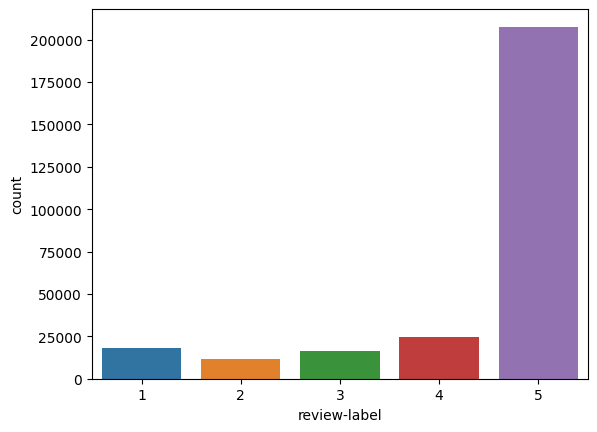

In [9]:
sns.countplot(data=shopdf, x='review-label')

In [10]:
print(list(shopdf))

['reviewer_id', 'store_location', 'latitude', 'longitude', 'date', 'month', 'year', 'title', 'review', 'review-label']


We drop the unnecessary columns. 

In [11]:
try:
    shopdf.drop(labels=['store_location','latitude','longitude','date','month','year'], axis=1, inplace=True)
except:
    print("Columns already dropped.")

In [12]:
shopdf.head(100)

,reviewer_id,title,review,review-label
0,0.0,great help lost order,order lost transit. call help custom servic re...,5
1,1.0,order wrong size tee had,order wrong size tee difficulti return website...,5
2,2.0,guy offer best customer,guy offer best custom servic retail! product h...,5
3,3.0,good stuff,look obscur phrase shirt. teepubl it. process ...,5
4,4.0,order arriv good timely,order arriv good time fashion & item receiv ex...,4
...,...,...,...,...
95,95.0,probabl order,ship time alway long end even longer.t-shirt f...,3
96,96.0,uniqu one kind iphon cover,excel qualiti price! well worth purchase.,5
97,97.0,great qualiti shirt,great qualiti shirt. perfect logo. total satis...,5
98,98.0,great custom servic,great custom service! everyth order delivered!,5


## Reformulate target column
We map the review-labels 1,2,3 (indicating unhappy customers) to 1 and the rest indicating happy customers to 0.

In [13]:
# 1,2,3 maps to 1 and 4,5 maps to 0
#shopdf['unhappy'] = shopdf['review-label'].apply(lambda x:[x for x in shopdf['review-label'] if x <= 4 else x=0])
shopdf['unhappy'] = shopdf['review-label'].map({1:1,2:1,3:1,4:0,5:0})

<Axes: xlabel='unhappy', ylabel='count'>

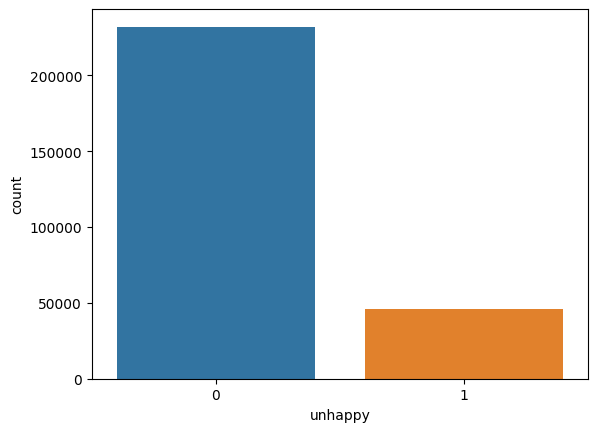

In [14]:
# Look at class imbalance now
sns.countplot(data=shopdf, x='unhappy')

We further drop columns such as `reviewer_id` which might lead to overfitting and `review-label` as we don't need them.

In [15]:
try:
    shopdf.drop(labels=['reviewer_id','review-label'],axis=1,inplace=True)
except:
    print("Columns don't exist or already dropped.")

In [16]:
shopdf

,title,review,unhappy
0,great help lost order,order lost transit. call help custom servic re...,0
1,order wrong size tee had,order wrong size tee difficulti return website...,0
2,guy offer best customer,guy offer best custom servic retail! product h...,0
3,good stuff,look obscur phrase shirt. teepubl it. process ...,0
4,order arriv good timely,order arriv good time fashion & item receiv ex...,0
...,...,...,...
278095,highli recommend!,"deliveri quick, arriv promised. shirt qualiti ...",0
278096,great qualiti,"great quality, fast delivery, would recommend!",0
278097,dude rock.,dude rock. seriously.,0
278098,ship fast t-shirt just,ship fast t-shirt right good compani suicid boy,0


We use just the `review` column for our modelling.

In [17]:
X = shopdf['review']      # shopdf.iloc[:,:-1]
y = shopdf['unhappy']     # shopdf.iloc[:,-1:]

## Create the holdout set

In [18]:
from sklearn.model_selection import train_test_split

# split the data into training and testing sets
X_retain, X_holdout, y_retain, y_holdout = train_test_split(X,y,test_size=0.4,stratify=y, random_state=1)

# split the holdout set from the original data
#X_holdout, y_holdout = X_holdout, y_holdout

In [19]:
y_holdout.value_counts()

unhappy
0    92830
1    18410
Name: count, dtype: int64

# EDA

Let us now divert our attention to some EDA.  We will try to glean some insight for our data prep and modelling
pipeline.

## Wordcloud

There is a lot of noise in the text which the stopwords doesn't seem to remove.  We will impose an additional
condition of word length while making the word cloud.

Text(0.5, 0.95, 'Wordclouds for categories')

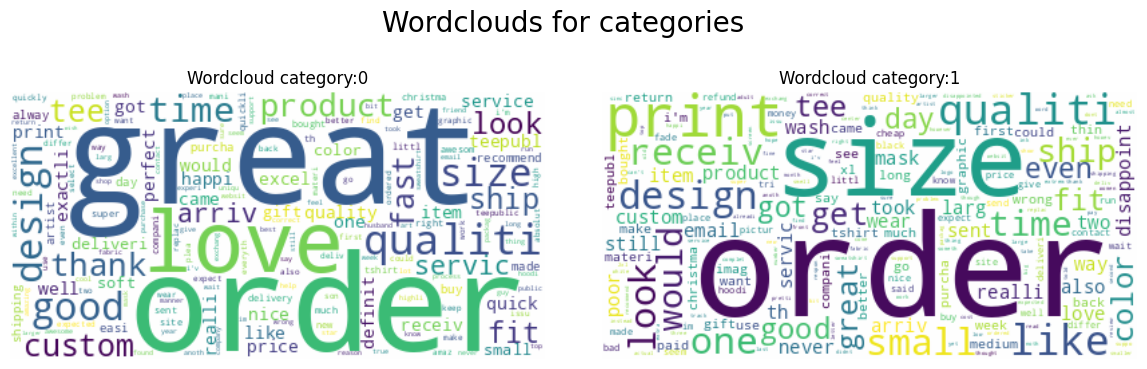

In [20]:
# Two word clouds in 1 row and 2 columns
fig, axes = plt.subplots(1,2,figsize=(12,5))
plt.tight_layout()
ax = axes.flat   # Flat list of axes to iterate over

for i,cat in enumerate(shopdf.unhappy.unique()[:]):
    # Aggregate text for each happiness value
    try:
        unhappy_text = ' '.join([w for w in shopdf[shopdf.unhappy == cat]['review'].values])
    except:
        pass
    # Create and generate a wordcloud image
    wordcloud = WordCloud(stopwords=stopwords.union({'shirt','t shirt','shirts','t shirts'}), background_color="#FEFEFE", colormap='viridis', collocations=False, collocation_threshold=30).generate(unhappy_text)
    # The addition of shirts and t shirts is an afterthought after looking at the initial word cloud.
    # Display the generated image
    ax[i].set_title(f"Wordcloud category:{cat}")
    ax[i].set_axis_off()
    ax[i].imshow(wordcloud, interpolation='bilinear')

plt.suptitle(f"Wordclouds for categories", y=0.95, fontsize=20)

Word clouds are impressive, but these don't give us much insight into distinguishing the two classes.  Admittedly, we have
removed some words (example shirt, t shirt) to make way for other more meaningful words.

We will try a couple
of approaches:
- look at word frequencies (say top 10 or top 20) for the two classes
- compute the Jaccard similarity of the set of words in the two classes

## Word frequencies

We will get word frequencies for both the classes after removing the stopwords.  Remember that stemming is very necessary
here lest we count forms of the same word multiple times (example shirt/shirts, order/ordered)

In [21]:
# Create the review 0 blob 
class0_blob = ' '.join(shopdf[shopdf['unhappy'] == 0]['review'].values)
# Create the review 1 blob similarly
class1_blob = ' '.join(shopdf[shopdf['unhappy'] == 1]['review'].values)

In [22]:
from collections import Counter

# Get list of total words in class 0 and class 1
class0_words = [w for w in class0_blob.split()]
class1_words = [w for w in class1_blob.split()]
# Get the count of words in each class
class0_word_cnt = len(class0_words)
class1_word_cnt = len(class1_words)
# Create the word frequency count dictionary for both the classes after removing stopwords
class0_count_dict = Counter(class0_words)
class1_count_dict = Counter(class1_words)

print(f"Unique words in class 0: {class0_word_cnt}")   # These counts are post-cleaning
print(f"Unique words in class 1: {class1_word_cnt}")   

Unique words in class 0: 2619552
Unique words in class 1: 888206


__The n most frequent words for the n classes.__

In [23]:
class0_wordfreq = pd.DataFrame([(w,c/class0_word_cnt,c) for w,c in class0_count_dict.most_common(50)],columns=['word','frequency',"count"]) # Most common words in class 0
class0_wordfreq

,word,frequency,count
0,shirt,0.029130,76308
1,order,0.024669,64622
2,great,0.022545,59058
3,love,0.019839,51970
4,qualiti,0.015879,41595
5,?,0.010589,27739
6,good,0.010408,27263
7,size,0.009641,25254
8,design,0.008361,21902
9,time,0.008158,21370


In [24]:
class1_wordfreq = pd.DataFrame([(w,c/class1_word_cnt,c) for w,c in class1_count_dict.most_common(50)],columns=['word','frequency',"count"])   # Most common words in class 1
class1_wordfreq

,word,frequency,count
0,shirt,0.032058,28474
1,order,0.026078,23163
2,size,0.011793,10475
3,qualiti,0.011218,9964
4,print,0.011134,9889
5,like,0.010583,9400
6,look,0.008608,7646
7,receiv,0.008519,7567
8,one,0.008214,7296
9,design,0.007674,6816


How similar is the set of most frequent words?  Here is where Jaccard similarity comes in.

## Jaccard similarity

In [28]:
def jac_similarity(dict0,dict1,topn=10):
    # Return jaccard similarity
    # Input count dictionaries for class 0 and class 1 produced by Counter
    # Create sets of the n most frequent words in both the classes
    class0_topn = set([w for w,c in dict0.most_common(topn)])
    class1_topn = set([w for w,c in dict1.most_common(topn)])
    # Jaccard similarity
    jaccard_similarity = len(class0_topn.intersection(class1_topn))/len(class0_topn.union(class1_topn))
    return jaccard_similarity

Let us examine the Jaccard similarity for a range of top n frequencies.

In [72]:
for i in range(5,100):
    print(f"{i:4}    {jac_similarity(class0_count_dict,class1_count_dict,topn=i):0.2f}")

   5    0.43
   6    0.33
   7    0.27
   8    0.33
   9    0.29
  10    0.33
  11    0.29
  12    0.33
  13    0.37
  14    0.40
  15    0.43
  16    0.39
  17    0.36
  18    0.33
  19    0.36
  20    0.38
  21    0.35
  22    0.38
  23    0.39
  24    0.45
  25    0.47
  26    0.44
  27    0.46
  28    0.47
  29    0.49
  30    0.46
  31    0.48
  32    0.45
  33    0.43
  34    0.45
  35    0.46
  36    0.50
  37    0.48
  38    0.46
  39    0.44
  40    0.45
  41    0.46
  42    0.45
  43    0.46
  44    0.47
  45    0.48
  46    0.46
  47    0.45
  48    0.45
  49    0.44
  50    0.43
  51    0.42
  52    0.41
  53    0.39
  54    0.38
  55    0.39
  56    0.40
  57    0.41
  58    0.41
  59    0.40
  60    0.40
  61    0.40
  62    0.39
  63    0.40
  64    0.39
  65    0.38
  66    0.38
  67    0.37
  68    0.36
  69    0.35
  70    0.35
  71    0.35
  72    0.36
  73    0.36
  74    0.37
  75    0.36
  76    0.37
  77    0.38
  78    0.39
  79    0.39
  80    0.40
  81    0.40

## Help with tuning the tf-idf hyperparameters

The Jaccard similarity gives us an encouraging sign.  Heuristically, it indicates that the two classes are quite distinct in terms of their word frequencies -- and quite consistently too.  One interesting observation is that for a top n value of
around 11, we get the least similarity.  This gives us a good hint to tune our tfidf vectorizer.

So, what is the relative frequency threshold for our tfidf vectorizer?

Before answering this, let's dwell for a moment on the relative frequencies of the top n words in both the classes.  It appears as a long-tailed distribution given the fact that the top (stemmed) word frequency is just over 3%.

For the top n value of ~11, we can easily arrive at a minimum relative frequency threshold of about 0.007.  This is the
average of the 11th ranked words in both class 1 and class 0.  The maximum frequency threshold might be ~0.025 given that
both the classes have the words 'shirt' and 'order' as the most frequent words that we want removed.

**Note: Actual thresholds may keep changing because of the stochastic nature of the problem.**

# Pipelines (data prep and modelling)

We will first try out a tf-idf vectorizer with some classifiers and create pipelines accordingly.

In [29]:
from sklearn.linear_model import LogisticRegression
#from sklearn import svm
#from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import nltk

In [31]:
#shopclf = MultinomialNB()
log_clf = LogisticRegression(max_iter=1000)

## Hyperparameter tuning
**Get ready for GridsearchCV**

In [32]:
# Create a pipeline and prepare the parameters to run a GridSearchCV
text_pipeline = Pipeline([
    ('vectorizer',TfidfVectorizer(strip_accents='unicode')),
    ('classifier',log_clf)
])

text_pipeline_parameters = dict(
                                #vectorizer__max_features = [2000,7000,10000,None],
                                vectorizer__min_df = [0.00002,0.0005,0.001,0.007],
                                vectorizer__max_df = [0.022,0.03,1.0],
                               )

# Create the cross-validator
skf3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Create the grid
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(text_pipeline,text_pipeline_parameters,cv = skf3, scoring='recall', refit=True, verbose=3)

In [33]:
y_retain.values.ravel()

array([0, 1, 1, ..., 0, 0, 1])

In [34]:
# Run the gridsearch
grid.fit(X_retain, y_retain.values.ravel())

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END vectorizer__max_df=0.022, vectorizer__min_df=2e-05;, score=0.597 total time=   6.0s
[CV 2/3] END vectorizer__max_df=0.022, vectorizer__min_df=2e-05;, score=0.593 total time=   5.4s
[CV 3/3] END vectorizer__max_df=0.022, vectorizer__min_df=2e-05;, score=0.597 total time=   5.3s
[CV 1/3] END vectorizer__max_df=0.022, vectorizer__min_df=0.0005;, score=0.600 total time=   5.0s
[CV 2/3] END vectorizer__max_df=0.022, vectorizer__min_df=0.0005;, score=0.591 total time=   5.0s
[CV 3/3] END vectorizer__max_df=0.022, vectorizer__min_df=0.0005;, score=0.601 total time=   4.9s
[CV 1/3] END vectorizer__max_df=0.022, vectorizer__min_df=0.001;, score=0.589 total time=   4.5s
[CV 2/3] END vectorizer__max_df=0.022, vectorizer__min_df=0.001;, score=0.581 total time=   4.5s
[CV 3/3] END vectorizer__max_df=0.022, vectorizer__min_df=0.001;, score=0.594 total time=   4.4s
[CV 1/3] END vectorizer__max_df=0.022, vectorizer__min_df=0.007

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(strip_accents='unicode')),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'vectorizer__max_df': [0.022, 0.03, 1.0],
                         'vectorizer__min_df': [2e-05, 0.0005, 0.001, 0.007]},
             scoring='recall', verbose=3)

**The best parameters**

In [36]:
grid.best_params_

{'vectorizer__max_df': 1.0, 'vectorizer__min_df': 0.0005}

**The best estimator**

In [38]:
tuned_pipeline = grid.best_estimator_

# Final testing
We will run a final test using our holdout set.

In [39]:
len(y_retain)

166860

In [40]:
tuned_pipeline.fit(X_retain.values, y_retain.values.ravel())  # Fit the entire retained dataset
y_pred = tuned_pipeline.predict(X_holdout.values)
y_pred_proba = tuned_pipeline.predict_proba(X_holdout.values)[:,1]


# Evaluation

We have our predictions from the holdout set.  We have `y_pred`, `y_holdout`, `y_pred_proba`.  We will use these to plot ROC curve and PR curve.
But, before that, we will generate a classification report.


In [42]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_holdout,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96     92830
           1       0.84      0.70      0.77     18410

    accuracy                           0.93    111240
   macro avg       0.89      0.84      0.86    111240
weighted avg       0.93      0.93      0.93    111240



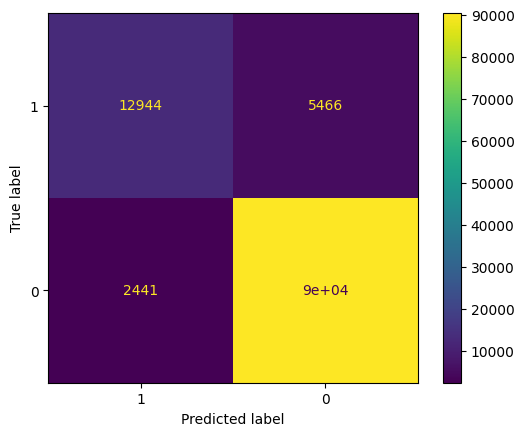

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
tn,fp,fn,tp = confusion_matrix(y_holdout,y_pred).ravel()
ConfusionMatrixDisplay.from_predictions(y_holdout,y_pred, labels=(1,0))

In [44]:
print(f"Precision:{tp/(tp+fp)}, Recall:{tp/(tp+fn)}")

Precision:0.8413389665258368, Recall:0.7030961434003259


## Precision Recall curve

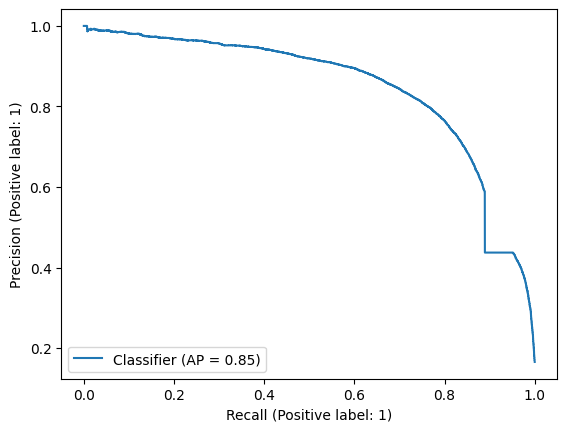

In [45]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(y_holdout,y_pred_proba)

# ROC Curve

... using two methods

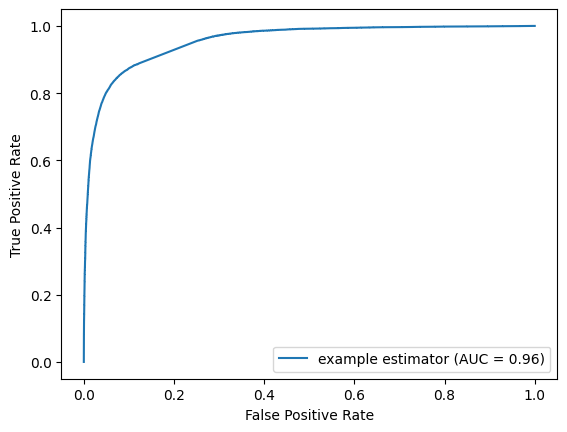

In [46]:
from sklearn import metrics

fpr,tpr,thresholds = metrics.roc_curve(y_holdout,y_pred_proba)
roc_auc = metrics.auc(fpr,tpr)
display = metrics.RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

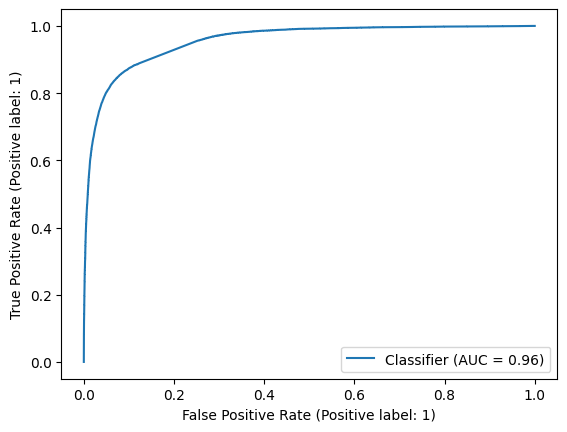

In [47]:
metrics.RocCurveDisplay.from_predictions(y_holdout, y_pred_proba)

# Conclusion and takeaway

We used a traditional tf-idf feature extraction approach to train our classifier.  We experimented whether
the learnings from a Jaccard similarity report output can help us tune our tf-idf parameters.

It turns out that while the Jaccard similarity figures can serve as a rough guide for the tf-idf parameters,
we end up defaulting to the widest min-df--max-df range possibly due to the fact that this is an extremely
long-tailed distribution of words and limiting the minimum and maximum frequencies precludes certain
observations/reviews totally.  However, just one dataset is too little to write-off the Jaccard similarity
approach.